In [1]:
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.plot.styles as styles
import modflowapi
import swiapi

In [2]:
ws = pl.Path("./constant_steady")
name = "mf6"

In [3]:
mf6exe = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/mf6"
libmf6 = "/Users/jdhughes/Documents/Work/SWI6/modflow6/bin/libmf6.dylib"

In [4]:
delr = delc = 50.
xlen = 2050.
ylen = delc
nlay, nrow, ncol = 1, int(ylen / delc), int(xlen / delr)
nlay, nrow, ncol

(1, 1, 41)

In [5]:
shape3d = (nlay, nrow, ncol)
shape2d = (nrow, ncol)

In [6]:
top = 10.
botm = -100.

In [7]:
# newton_options = "newton"
newton_options = None

In [8]:
if newton_options is None:
    linear_acceleration="cg"
else:
    linear_acceleration="bicgstab"

In [9]:
sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=ws, exe_name=mf6exe, memory_print_option="all")

In [10]:
tdis = flopy.mf6.ModflowTdis(sim, time_units="days")

In [11]:
ims = flopy.mf6.ModflowIms(sim, outer_dvclose=1e-5, inner_dvclose=1e-6, linear_acceleration=linear_acceleration, complexity="simple")

In [12]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=name, newtonoptions=newton_options)

In [13]:
nghb = 1

In [14]:
top = np.full(shape2d, top, dtype=float)
top[0, :nghb] = 0
top

array([[ 0., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        10., 10.]])

In [15]:
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr, delc=delc, top=top, botm=botm)

In [16]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=top)

In [17]:
npf = flopy.mf6.ModflowGwfnpf(gwf, k=10, icelltype=1, alternative_cell_averaging="AMT-LMK",)

In [18]:
swi = flopy.mf6.ModflowGwfswi(gwf, zeta=botm)

In [19]:
rch_mult = 0.5
rch_rate = 4e-4 * rch_mult
rch_rate = np.full(shape2d, rch_rate, dtype=float)
rch_rate[0, :nghb] = 0.
rch_rate

array([[0.    , 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002]])

In [20]:
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=rch_rate)

In [21]:
ghb_spd = [(0, 0, i, 0.0, 62.5) for i in range(nghb)]
ghb_spd

[(0, 0, 0, 0.0, 62.5)]

In [22]:
ghb = flopy.mf6.ModflowGwfghb(gwf, stress_period_data=ghb_spd)

In [23]:
oc = flopy.mf6.ModflowGwfoc(gwf, head_filerecord=f"{name}.hds", saverecord=[("head", "all")])

In [24]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package swi...
    writing package rcha_0...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...


In [25]:
# sim.run_simulation()

### API calls

In [26]:
mf6 =  modflowapi.ModflowApi(libmf6, working_directory=ws)
swiapi = swiapi.SwiAPi(mf6, name)
print("Initializing mf6...")
mf6.initialize()

swiapi.create_pointers()
# swiapi.print_pointers()

current_time = 0.
end_time = mf6.get_end_time()

# update zeta using the initial head
swiapi.update_zeta()

while current_time < end_time:
    
    print("  Get and prepare time step...")
    dt = mf6.get_time_step()
    mf6.prepare_time_step(dt)
    
    kiter = 0
    print("  Prepare solve...")
    mf6.prepare_solve(1)
    while kiter < 30:

        print(f"\n    Solve...(kiter={kiter})")
        has_converged = mf6.solve(1)

        # update zeta using the initial head
        swiapi.update_zeta()

        if has_converged:
            break
        kiter += 1

        # swiapi.print_pointers()

    print("  Finalize solve...")
    mf6.finalize_solve(1)
    
    print("  Finalize time step...")
    mf6.finalize_time_step()
    current_time = mf6.get_current_time()

print ("Finalizing mf6...")
mf6.finalize()

Initializing mf6...
Accessing pointer using tag: MF6/X
Accessing pointer using tag: MF6/RHS
Accessing pointer using tag: SLN_1/IA
Accessing pointer using tag: SLN_1/JA
Accessing pointer using tag: SLN_1/AMAT
Accessing pointer using tag: MF6/NPF/SAT
Accessing pointer using tag: MF6/NPF/CONDSAT
Accessing pointer using tag: MF6/SWI/ZETA
  Get and prepare time step...
  Prepare solve...

    Solve...(kiter=0)

    Solve...(kiter=1)

    Solve...(kiter=2)

    Solve...(kiter=3)

    Solve...(kiter=4)

    Solve...(kiter=5)

    Solve...(kiter=6)

    Solve...(kiter=7)

    Solve...(kiter=8)

    Solve...(kiter=9)

    Solve...(kiter=10)

    Solve...(kiter=11)
  Finalize solve...
  Finalize time step...
Finalizing mf6...


### Plot the results

In [27]:
hds = gwf.output.head().get_data()

In [28]:
hds.max(), hds.max()*-40

(1.4503111528426818, -58.01244611370727)

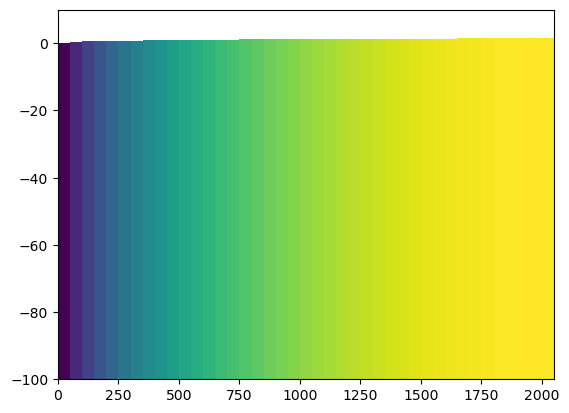

In [29]:
xsect = flopy.plot.PlotCrossSection(model=gwf, line={"row": 0})
pa = xsect.plot_array(hds, head=hds)

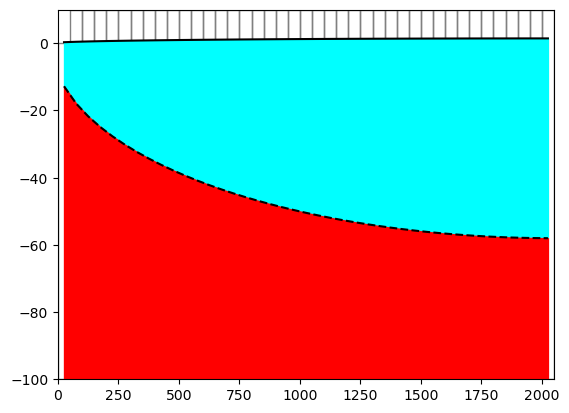

In [30]:
zeta = swiapi.zeta_last
x = gwf.modelgrid.xcellcenters.flatten()
pxs = flopy.plot.PlotCrossSection(gwf, line={"row":0})
ax = pxs.ax
if ncol < 50:
    pxs.plot_grid()
#pxs.plot_bc("ghb")
ax.plot(x, hds.flatten(), "k-")
ax.plot(x, zeta.flatten(), "k--")
# freshwater
ax.fill_between(x, hds.flatten(), zeta, color="cyan")
# saltwater
ax.fill_between(x, zeta, botm, color="red")

In [31]:
zeta.min(), zeta.max()

(-58.012339129032895, -12.800000000000702)